# Machine Learning and Comic Book Characters
Ariana Olson, Emma Price

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkstats2
import thinkplot

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.models
import keras.layers

import pickle

## Explore the data

In [84]:
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)
    
with open('cat_dicts_both.pkl', 'rb') as f:
    cat_dicts_both = pickle.load(f)

In [85]:
both_df = pd.read_hdf('both_df.hdf5', key='both')
marvel_df = pd.read_hdf('marvel_df.hdf5', key='marvel')
dc_df = pd.read_hdf('dc_df.hdf5', key='dc')

In [86]:
both_df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
0,1422,597,597,2.0,1.0,3.0,0.0,2.0,NaN,1.0,3093.0,1939.0,1
1,23387,6007,6006,2.0,1.0,3.0,0.0,2.0,NaN,1.0,2496.0,1986.0,1
2,1458,2487,2487,2.0,1.0,4.0,3.0,2.0,NaN,1.0,1565.0,1959.0,1
3,1659,3002,3003,1.0,1.0,4.0,16.0,2.0,NaN,1.0,1316.0,1987.0,1
4,1576,5280,5279,2.0,1.0,3.0,0.0,2.0,NaN,1.0,1237.0,1940.0,1


In [87]:
both_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18295 entries, 0 to 11398
Data columns (total 13 columns):
page_id        18295 non-null int64
name           18295 non-null int64
urlslug        18295 non-null int64
ID             14061 non-null float64
ALIGN          16045 non-null float64
EYE            8496 non-null float64
HAIR           13611 non-null float64
SEX            17728 non-null float64
GSM            145 non-null float64
ALIVE          18291 non-null float64
APPEARANCES    17939 non-null float64
YEAR           17851 non-null float64
dcmar          18295 non-null int64
dtypes: float64(9), int64(4)
memory usage: 2.0 MB


In [88]:
both_df.describe()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,YEAR,dcmar
count,18295.000000,18295.000000,18295.000000,14061.000000,16045.000000,8496.000000,13611.000000,17728.000000,145.000000,18291.000000,17939.000000,17851.000000,18295.000000
mean,219154.987483,4850.334026,4850.334026,2.063011,0.650545,6.218220,5.589376,2.068592,1.275862,0.754633,22.906517,1985.812447,0.376934
std,213972.005972,3071.063175,3071.063175,0.777446,0.695984,5.592072,5.919296,1.031369,0.885710,0.430316,103.055100,19.288066,0.484631
min,1025.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1935.000000,0.000000
25%,21599.500000,2286.500000,2286.500000,1.000000,0.000000,3.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1975.000000,0.000000
50%,154770.000000,4573.000000,4573.000000,2.000000,1.000000,4.000000,3.000000,2.000000,1.000000,1.000000,5.000000,1990.000000,0.000000
75%,348820.000000,6860.000000,6860.000000,3.000000,1.000000,7.000000,6.000000,3.000000,2.000000,1.000000,13.000000,2000.000000,1.000000
max,754840.000000,11398.000000,11398.000000,3.000000,3.000000,23.000000,23.000000,3.000000,5.000000,1.000000,4043.000000,2013.000000,1.000000


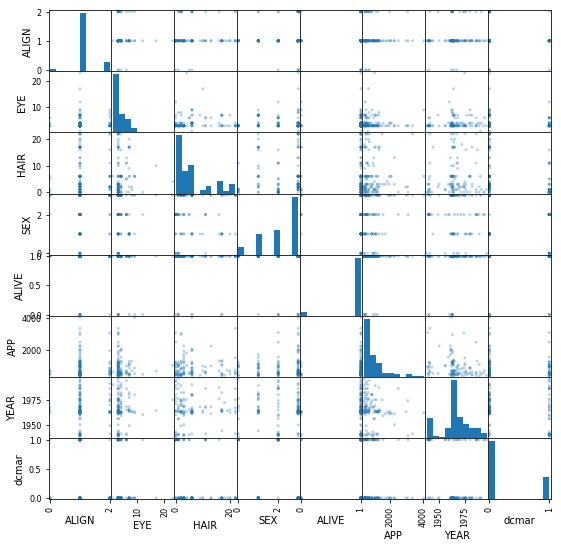

In [90]:
X = both_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[9,9])

/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[j])
/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  ax.set_ylim(boundaries_list[i])
/home/eprice/anaconda3/lib/python3.6/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[i])


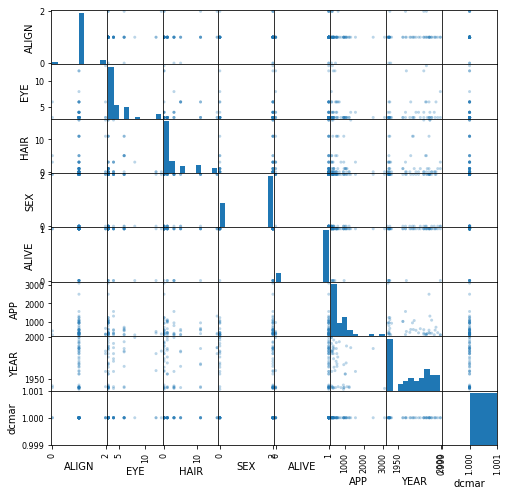

In [91]:
X = dc_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>300]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

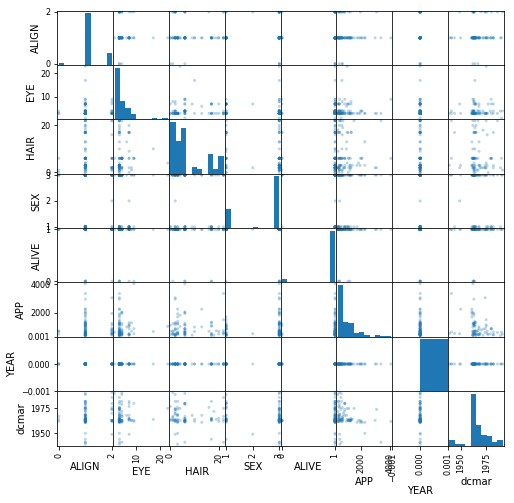

In [93]:
X = marvel_df.drop(['ID', 'page_id', 'name','urlslug', 'GSM'], axis=1).values

df =  pd.DataFrame(X, columns = ['ALIGN', 'EYE', 'HAIR', 'SEX','ALIVE','APP','YEAR', 'dcmar'])
df = df[df['APP']>400]


_ = pd.plotting.scatter_matrix(df.dropna(),alpha = 0.3, figsize=[8,8])

In [94]:
y = both_df.dropna()['YEAR'].values
X = both_df.dropna().drop(['YEAR', 'page_id', 'name','urlslug','GSM'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

linreg = linear_model.LinearRegression()

linreg.fit(X_train,y_train)

y_pred = linreg.predict(X_test)

print("R^2: {}".format(linreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.2901284552439307
Root Mean Squared Error: 13.566565985707044


/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.04197857 0.07889409 0.12360702 ... 0.55151039 0.13827666 0.51014812]
R^2: 0.6794354838709677
Root Mean Squared Error: 0.5661841715634871
0.826631127466973
[[1005  241]
 [ 395  343]]


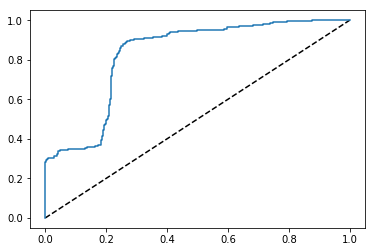

In [95]:
clean_df = both_df.drop(['page_id','name','urlslug', 'ID', 'GSM'], axis=1).dropna()

y = clean_df['dcmar'].dropna().values
X = clean_df.drop('dcmar', axis=1).dropna().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

print(y_pred_prob)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))